In [461]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from pandas_datareader import data as pdr
from datetime import datetime, date, timedelta

import yfinance as yfin
yfin.pdr_override()

import matplotlib.pyplot as plt
import seaborn as sns

#from var import VaR

pd.set_option('display.float_format', lambda x: f'{x:,.6f}')

# Assignment
Familiarity with several pricing models and how to apply them to a portfolio. Now calculate the VWAP, Sharpe and Alpha for your portfolio from the start of the semester  to the date of you calculations. Your calculation results and the VaR calculations that you performed last week are the main content of the Portfolio Review presentation that is next week's subject and assignment. -- Remember Presentation is Important

# Variables

In [462]:
period = '5y'

# Functions

https://www.spglobal.com/spdji/en/indices/fixed-income/sp-500-bond-index/#overview

451.10 ---- 2.23% ---0.1840% 

In [463]:
0.1840/100

0.00184

In [464]:
-0.1827 / 100

-0.001827

In [465]:
0.65 / 100

0.006500000000000001

# Load Data

## Load Variables

In [466]:
var_lst = ['^SPX']
data = pdr.get_data_yahoo(var_lst, period=period)['Close']
rf_df = data.pct_change()
rf_df = rf_df.mean()
rf_df

[*********************100%%**********************]  1 of 1 completed


0.0004142542040861326

#var_lst = ['^SP500BDT']
var_lst = ['FHNFX']
data = pdr.get_data_yahoo(var_lst, period=period)['Close']
rf_df = data.pct_change()
rf_rate_econ = rf_df.mean()
rf_rate_econ

#rf_rate = rf_rate_econ
#rf_df = 0.00184
#rf_df = -0.001827
rf_df = 0.00650

## Load Portfolio

In [467]:
folio_df = pd.read_csv('https://raw.githubusercontent.com/dsimband/DATA618/main/w6/data/DATA618_Portfolio.csv', 
                 dtype={
                    'ID': 'int',
                    'Price': 'float',
                    'Shares': 'float',
                    'Value': 'float', 
                 })


folio_df = folio_df[folio_df['Shares'] > 0]
folio_df = folio_df.groupby(['Ticker','BondName','Class','Sub_Class'])[['Shares','Value']].sum()
folio_df.reset_index(inplace=True)
#folio_df['Morningstar_Category'].fillna('Other', inplace=True)
#folio_df = folio_df[4:]

# calculate portfilio percentage
portfolio_total = folio_df['Value'].sum()
folio_df['port_percent'] = folio_df['Value'] / portfolio_total

# Class Portfolios
folio_econ_df = folio_df[folio_df['Class'] == 'Economically Sensitive']
folio_int_df = folio_df[folio_df['Class'] == 'Interest Rate Sensitive']

folio_df

,Ticker,BondName,Class,Sub_Class,Shares,Value,port_percent
0,ALTVX,AB Municipal Income National Advisor,Interest Rate Sensitive,Very-High-Quality Municipal Bonds,"106,383.000000","1,000.000000",0.011945
1,BLUEX,AMG Veritas Global Real Return I,Economically Sensitive,Long/Short Equities,"14,201.000000",500.000000,0.005972
2,BPLSX,Boston Partners Long/Short Equity Instl,Economically Sensitive,Long/Short Equities,"49,967.000000",750.000000,0.008959
3,C_A_S_H,Cash,Cash,Cash,"4,469,000.000000","4,469.000000",0.053381
4,DFAR,Dimensional US Real Estate ETF,Economically Sensitive,Publicly Traded REITs,"108,467.000000","2,250.000000",0.026876
5,FREL,Fidelity MSCI Real Estate ETF,Economically Sensitive,Publicly Traded REITs,"115,479.000000","2,800.000000",0.033445
6,FSMD,Fidelity Small-Mid Multifactor ETF,Economically Sensitive,U.S. Equities,"120,705.000000","4,000.000000",0.047779
7,GARIX,Gotham Absolute Return Institutional,Economically Sensitive,Long/Short Equities,"25,278.000000",500.000000,0.005972
8,GCHDX,Gotham Hedged Core Institutional,Economically Sensitive,Long/Short Equities,"46,211.000000",500.000000,0.005972
9,ICBFX,Invesco Corporate Bond R6,Interest Rate Sensitive,Very-High-Quality Corporate Bonds,"166,389.000000","1,000.000000",0.011945


In [468]:
folio_df.groupby(['Class'])[['Value']].sum()

,Value
Class,
Cash,"4,469.000000"
Economically Sensitive,"50,250.000000"
Interest Rate Sensitive,"29,000.000000"


In [469]:
initial_investment = folio_df['Value'].sum() * 1000
initial_investment

83719000.0

## Load Pricing Time Series - Economically

In [470]:
# ticker symbols
ticker_lst = list(folio_econ_df['Ticker'])
print('ticker #:', len(ticker_lst))


# portfolio weights
weight_lst = (folio_econ_df['port_percent'].values)
print('price #:', len(weight_lst))


#Download closing prices
#price_df = pdr.get_data_yahoo(ticker_lst, start=start_date, end=end_date)['Close']
price_econ_df = pdr.get_data_yahoo(ticker_lst, period=period)['Close']

#price_df['C_A_S_H'] = 1
#print('price_df #:', len(price_df.columns))

#From the closing prices, calculate periodic returns
return_econ_df = price_econ_df.pct_change()
print('return_df #:', len(return_econ_df.columns))

ticker #: 20
price #: 20
[*********************100%%**********************]  20 of 20 completed
return_df #: 20


In [471]:
print('ticker #:', len(ticker_lst))

ticker #: 20


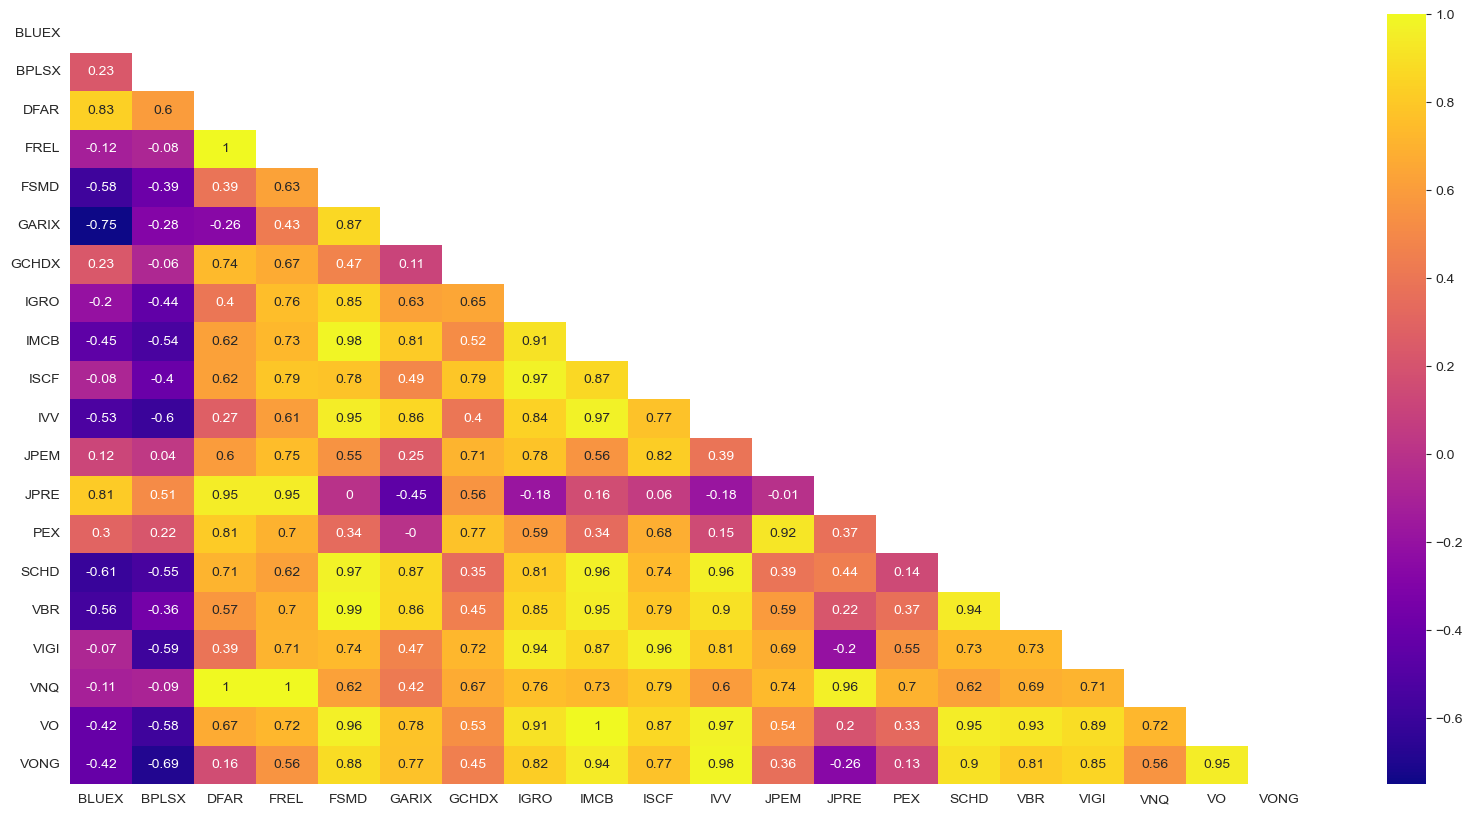

In [472]:
plt.figure(figsize=(20,10))
mask = np.zeros_like(price_econ_df.corr())
mask[np.triu_indices_from(mask)] = True
sns.set_style("white")
_p = sns.heatmap(price_econ_df.corr().round(2), 
                 annot=True, mask=mask, 
                 cmap="plasma", annot_kws={"size": 10})

In [473]:
return_econ_df = return_econ_df[1:]
return_econ_df

,BLUEX,BPLSX,DFAR,FREL,FSMD,GARIX,GCHDX,IGRO,IMCB,ISCF,IVV,JPEM,JPRE,PEX,SCHD,VBR,VIGI,VNQ,VO,VONG
Date,,,,,,,,,,,,,,,,,,,,
2018-10-09,0.001304,0.001426,NaN,0.003380,NaN,-0.002701,-0.000796,0.000184,-0.006387,-0.007108,-0.001207,-0.000534,NaN,0.002291,-0.003588,-0.005717,-0.003481,0.001387,-0.004246,-0.000193
2018-10-10,-0.047238,-0.012340,NaN,-0.015579,NaN,-0.012864,-0.019123,-0.015257,-0.021119,-0.026977,-0.032252,-0.023837,NaN,-0.010286,-0.025019,-0.023443,-0.029648,-0.014854,-0.031168,-0.039845
2018-10-11,-0.009955,-0.013936,NaN,-0.028229,NaN,-0.013717,-0.012998,-0.013254,-0.026706,-0.011580,-0.021124,-0.008009,NaN,-0.014723,-0.025467,-0.021665,-0.004520,-0.028623,-0.020001,-0.016250
2018-10-12,0.027602,0.001462,NaN,-0.002641,NaN,0.007649,0.009877,-0.003405,0.003232,0.009993,0.013487,0.019890,NaN,-0.001758,0.007381,-0.002315,0.010764,-0.002631,0.010172,0.022253
2018-10-15,-0.008826,-0.000487,NaN,0.005737,NaN,-0.002070,-0.004075,0.002658,0.005990,-0.004435,-0.005395,-0.004248,NaN,-0.006457,-0.001188,0.005414,-0.005324,0.006726,0.001177,-0.007879
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-02,-0.004413,-0.002699,-0.017418,-0.018462,-0.012024,0.000000,-0.001894,-0.014669,-0.012222,-0.019236,-0.000349,-0.004983,-0.017458,-0.019878,-0.008197,-0.015988,-0.010935,-0.018372,-0.011717,0.008621
2023-10-03,-0.006206,-0.005413,-0.019291,-0.019704,-0.013299,-0.009245,-0.008539,-0.011807,-0.013051,-0.015270,-0.013325,-0.012171,-0.020538,-0.013650,-0.010829,-0.015802,-0.009497,-0.019523,-0.013897,-0.017818
2023-10-04,0.005650,-0.000680,0.011696,0.010964,0.007057,0.005702,0.007655,0.001905,0.007728,-0.003921,0.007083,-0.006241,0.013499,-0.000395,0.000432,0.003884,0.007155,0.012222,0.007933,0.013127


### Sharpe

In [475]:
port_ret_weighted= return_econ_df.mul(weight_lst, axis=1)
port_ret_weighted

,BLUEX,BPLSX,DFAR,FREL,FSMD,GARIX,GCHDX,IGRO,IMCB,ISCF,IVV,JPEM,JPRE,PEX,SCHD,VBR,VIGI,VNQ,VO,VONG
Date,,,,,,,,,,,,,,,,,,,,
2018-10-09,0.000008,0.000013,NaN,0.000113,NaN,-0.000016,-0.000005,0.000004,-0.000305,-0.000255,-0.000058,-0.000025,NaN,0.000115,-0.000129,-0.000068,-0.000125,0.000054,-0.000101,-0.000007
2018-10-10,-0.000282,-0.000111,NaN,-0.000521,NaN,-0.000077,-0.000114,-0.000364,-0.001009,-0.000967,-0.001541,-0.001139,NaN,-0.000516,-0.000897,-0.000280,-0.001062,-0.000577,-0.000745,-0.001428
2018-10-11,-0.000059,-0.000125,NaN,-0.000944,NaN,-0.000082,-0.000078,-0.000317,-0.001276,-0.000415,-0.001009,-0.000383,NaN,-0.000739,-0.000913,-0.000259,-0.000162,-0.001111,-0.000478,-0.000582
2018-10-12,0.000165,0.000013,NaN,-0.000088,NaN,0.000046,0.000059,-0.000081,0.000154,0.000358,0.000644,0.000950,NaN,-0.000088,0.000264,-0.000028,0.000386,-0.000102,0.000243,0.000797
2018-10-15,-0.000053,-0.000004,NaN,0.000192,NaN,-0.000012,-0.000024,0.000063,0.000286,-0.000159,-0.000258,-0.000203,NaN,-0.000324,-0.000043,0.000065,-0.000191,0.000261,0.000028,-0.000282
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-02,-0.000026,-0.000024,-0.000468,-0.000617,-0.000574,0.000000,-0.000011,-0.000350,-0.000584,-0.000689,-0.000017,-0.000238,-0.000521,-0.000997,-0.000294,-0.000191,-0.000392,-0.000713,-0.000280,0.000309
2023-10-03,-0.000037,-0.000048,-0.000518,-0.000659,-0.000635,-0.000055,-0.000051,-0.000282,-0.000624,-0.000547,-0.000637,-0.000582,-0.000613,-0.000685,-0.000388,-0.000189,-0.000340,-0.000758,-0.000332,-0.000639
2023-10-04,0.000034,-0.000006,0.000314,0.000367,0.000337,0.000034,0.000046,0.000046,0.000369,-0.000140,0.000338,-0.000298,0.000403,-0.000020,0.000015,0.000046,0.000256,0.000474,0.000190,0.000470


In [476]:
return_econ_df['Portfolio']= port_ret_weighted.sum(axis=1).dropna()
return_econ_df

,BLUEX,BPLSX,DFAR,FREL,FSMD,GARIX,GCHDX,IGRO,IMCB,ISCF,...,JPEM,JPRE,PEX,SCHD,VBR,VIGI,VNQ,VO,VONG,Portfolio
Date,,,,,,,,,,,,,,,,,,,,,
2018-10-09,0.001304,0.001426,NaN,0.003380,NaN,-0.002701,-0.000796,0.000184,-0.006387,-0.007108,...,-0.000534,NaN,0.002291,-0.003588,-0.005717,-0.003481,0.001387,-0.004246,-0.000193,-0.000787
2018-10-10,-0.047238,-0.012340,NaN,-0.015579,NaN,-0.012864,-0.019123,-0.015257,-0.021119,-0.026977,...,-0.023837,NaN,-0.010286,-0.025019,-0.023443,-0.029648,-0.014854,-0.031168,-0.039845,-0.011629
2018-10-11,-0.009955,-0.013936,NaN,-0.028229,NaN,-0.013717,-0.012998,-0.013254,-0.026706,-0.011580,...,-0.008009,NaN,-0.014723,-0.025467,-0.021665,-0.004520,-0.028623,-0.020001,-0.016250,-0.008931
2018-10-12,0.027602,0.001462,NaN,-0.002641,NaN,0.007649,0.009877,-0.003405,0.003232,0.009993,...,0.019890,NaN,-0.001758,0.007381,-0.002315,0.010764,-0.002631,0.010172,0.022253,0.003693
2018-10-15,-0.008826,-0.000487,NaN,0.005737,NaN,-0.002070,-0.004075,0.002658,0.005990,-0.004435,...,-0.004248,NaN,-0.006457,-0.001188,0.005414,-0.005324,0.006726,0.001177,-0.007879,-0.000658
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-02,-0.004413,-0.002699,-0.017418,-0.018462,-0.012024,0.000000,-0.001894,-0.014669,-0.012222,-0.019236,...,-0.004983,-0.017458,-0.019878,-0.008197,-0.015988,-0.010935,-0.018372,-0.011717,0.008621,-0.006680
2023-10-03,-0.006206,-0.005413,-0.019291,-0.019704,-0.013299,-0.009245,-0.008539,-0.011807,-0.013051,-0.015270,...,-0.012171,-0.020538,-0.013650,-0.010829,-0.015802,-0.009497,-0.019523,-0.013897,-0.017818,-0.008619
2023-10-04,0.005650,-0.000680,0.011696,0.010964,0.007057,0.005702,0.007655,0.001905,0.007728,-0.003921,...,-0.006241,0.013499,-0.000395,0.000432,0.003884,0.007155,0.012222,0.007933,0.013127,0.003276


In [477]:
tickers='^DJA'
#tickers = 'FHNFX'
DJA = pdr.get_data_yahoo(tickers=tickers, period=period)
return_econ_df['Benchmark']= DJA['Close']
return_econ_df['Benchmark']= return_econ_df['Benchmark'].pct_change(1) #.dropna()
#return_df= return_df.dropna()
return_int_df

[*********************100%%**********************]  1 of 1 completed


,ALTVX,ICBFX,IGMWX,MEAR,MMIN,MMIT,PFRAX,PSAIX,SNDPX,SWRSX,VFIUX,VGCAX,VICSX,VTEB,Portfolio,Benchmark,RF Rate
Date,,,,,,,,,,,,,,,,,
2018-10-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,-0.000085
2018-10-09,-0.002004,0.000000,0.001232,0.001084,-0.000409,0.000000,0.000000,0.000951,-0.000714,0.000936,0.000943,NaN,0.000449,0.000200,0.000210,0.001020,-0.000085
2018-10-10,-0.002008,-0.001435,0.000000,-0.000401,-0.002044,0.000000,0.000000,-0.001899,-0.001430,-0.001871,0.000942,NaN,0.000449,-0.001796,-0.000193,0.000000,-0.000085
2018-10-11,0.001006,0.002874,0.001230,0.001805,0.000000,0.000000,0.000000,0.001903,0.000000,0.002812,0.001881,NaN,0.001795,0.001199,0.000554,0.003058,-0.000085
2018-10-12,0.000000,-0.001433,-0.001229,-0.002803,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000939,NaN,-0.001344,-0.001397,-0.000242,-0.001016,-0.000085
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-02,-0.003272,-0.008489,-0.008511,-0.002831,-0.007002,-0.006809,-0.002130,-0.005219,-0.001494,-0.007078,-0.005214,-0.005014,-0.007828,-0.008108,-0.002198,-0.005663,-0.000085
2023-10-03,-0.003282,-0.008562,-0.010014,0.000825,-0.005289,-0.002142,-0.004269,-0.005247,-0.002244,-0.006110,-0.005241,-0.006719,-0.008383,-0.002934,-0.002117,-0.005695,-0.000085
2023-10-04,0.000000,0.005181,0.008671,-0.000101,0.002658,0.002576,-0.003215,-0.001055,0.000000,0.004098,0.004215,0.004510,0.005470,0.003363,0.001437,0.004582,-0.000085


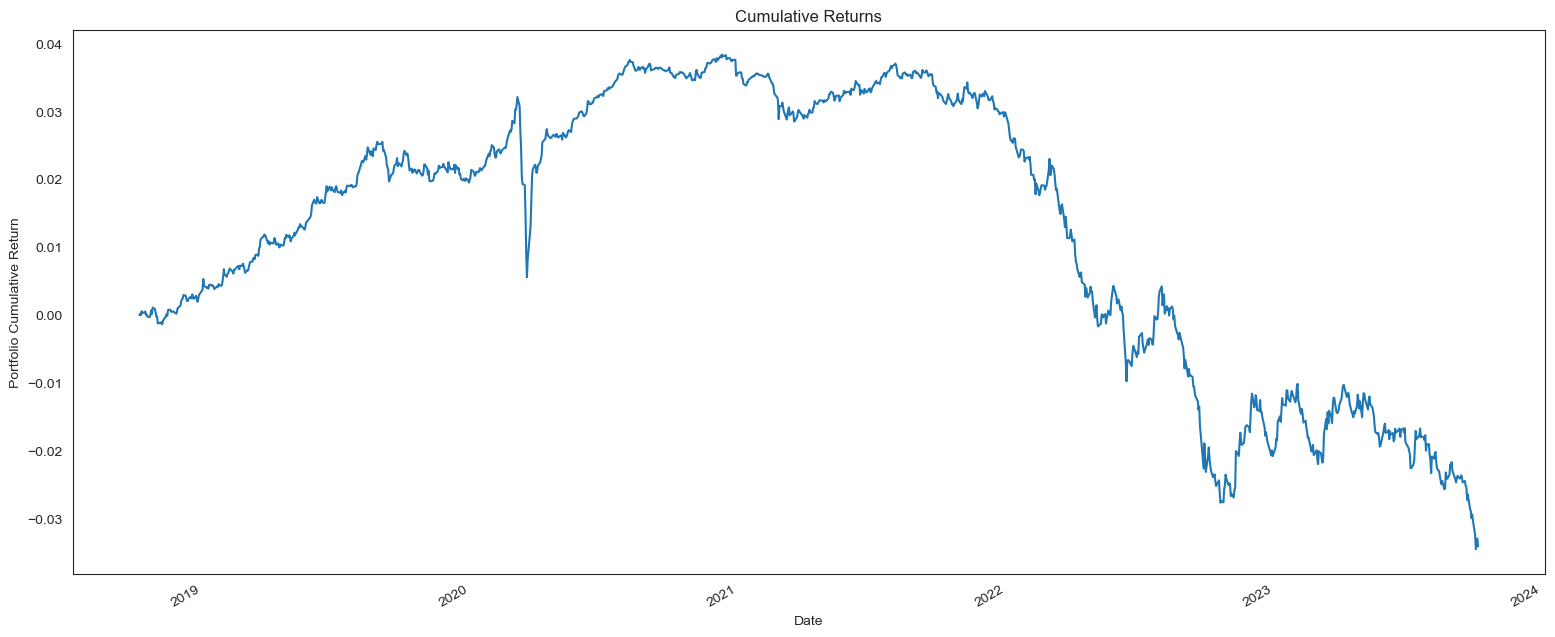

In [478]:
cum_ret_port = ((1 + return_int_df['Portfolio']).cumprod()-1)
cum_ret_port.plot(label='Cumulative Returns of the Portfolio' ,figsize=(19,8),title='Cumulative Returns - Economically')
_=plt.xlabel('Date' )
_=plt.ylabel('Portfolio Cumulative Return' )

In [479]:
port_bench = pd.concat([return_econ_df['Portfolio' ],return_econ_df['Benchmark' ]],axis=1 ).dropna()
port_bench.columns=['Portfolio',' Benchmark' ]
correlation=port_bench.corr()
correlation

,Portfolio,Benchmark
Portfolio,1.000000,0.947144
Benchmark,0.947144,1.000000


In [480]:
return_econ_df['RF Rate']= rf_rate
return_econ_df

,BLUEX,BPLSX,DFAR,FREL,FSMD,GARIX,GCHDX,IGRO,IMCB,ISCF,...,PEX,SCHD,VBR,VIGI,VNQ,VO,VONG,Portfolio,Benchmark,RF Rate
Date,,,,,,,,,,,,,,,,,,,,,
2018-10-09,0.001304,0.001426,NaN,0.003380,NaN,-0.002701,-0.000796,0.000184,-0.006387,-0.007108,...,0.002291,-0.003588,-0.005717,-0.003481,0.001387,-0.004246,-0.000193,-0.000787,NaN,-0.000085
2018-10-10,-0.047238,-0.012340,NaN,-0.015579,NaN,-0.012864,-0.019123,-0.015257,-0.021119,-0.026977,...,-0.010286,-0.025019,-0.023443,-0.029648,-0.014854,-0.031168,-0.039845,-0.011629,-0.030125,-0.000085
2018-10-11,-0.009955,-0.013936,NaN,-0.028229,NaN,-0.013717,-0.012998,-0.013254,-0.026706,-0.011580,...,-0.014723,-0.025467,-0.021665,-0.004520,-0.028623,-0.020001,-0.016250,-0.008931,-0.019590,-0.000085
2018-10-12,0.027602,0.001462,NaN,-0.002641,NaN,0.007649,0.009877,-0.003405,0.003232,0.009993,...,-0.001758,0.007381,-0.002315,0.010764,-0.002631,0.010172,0.022253,0.003693,0.009148,-0.000085
2018-10-15,-0.008826,-0.000487,NaN,0.005737,NaN,-0.002070,-0.004075,0.002658,0.005990,-0.004435,...,-0.006457,-0.001188,0.005414,-0.005324,0.006726,0.001177,-0.007879,-0.000658,0.000139,-0.000085
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-02,-0.004413,-0.002699,-0.017418,-0.018462,-0.012024,0.000000,-0.001894,-0.014669,-0.012222,-0.019236,...,-0.019878,-0.008197,-0.015988,-0.010935,-0.018372,-0.011717,0.008621,-0.006680,-0.009325,-0.000085
2023-10-03,-0.006206,-0.005413,-0.019291,-0.019704,-0.013299,-0.009245,-0.008539,-0.011807,-0.013051,-0.015270,...,-0.013650,-0.010829,-0.015802,-0.009497,-0.019523,-0.013897,-0.017818,-0.008619,-0.009105,-0.000085
2023-10-04,0.005650,-0.000680,0.011696,0.010964,0.007057,0.005702,0.007655,0.001905,0.007728,-0.003921,...,-0.000395,0.000432,0.003884,0.007155,0.012222,0.007933,0.013127,0.003276,0.003827,-0.000085


In [481]:
sharpe_ratio=((return_econ_df['Portfolio'].mean() - return_econ_df['RF Rate'].mean()))/return_econ_df['Portfolio' ].std()
round(sharpe_ratio,4)

0.0249

In [482]:
avg = return_econ_df['Portfolio'].mean() * 100
print(f"Portfolio Return Mean: {avg:.7f}")

Portfolio Return Mean: 0.0090987


In [483]:
std = return_econ_df['Portfolio' ].std()
print(f"Portfolio Return Standard Deviation: {std:.7f}")

Portfolio Return Standard Deviation: 0.0070701


## Load Pricing Time Series - Interest Rate

In [440]:
# ticker symbols
ticker_lst = list(folio_int_df['Ticker'])
print('ticker #:', len(ticker_lst))


# portfolio weights
weight_lst = (folio_int_df['port_percent'].values)
print('price #:', len(weight_lst))


#Download closing prices
#price_df = pdr.get_data_yahoo(ticker_lst, start=start_date, end=end_date)['Close']
price_int_df = pdr.get_data_yahoo(ticker_lst, period=period)['Close']

#price_df['C_A_S_H'] = 1
#print('price_df #:', len(price_df.columns))

#From the closing prices, calculate periodic returns
return_int_df = price_int_df.pct_change()
print('return_df #:', len(return_int_df.columns))

ticker #: 14
price #: 14
[*********************100%%**********************]  14 of 14 completed
return_df #: 14


### Coorelation

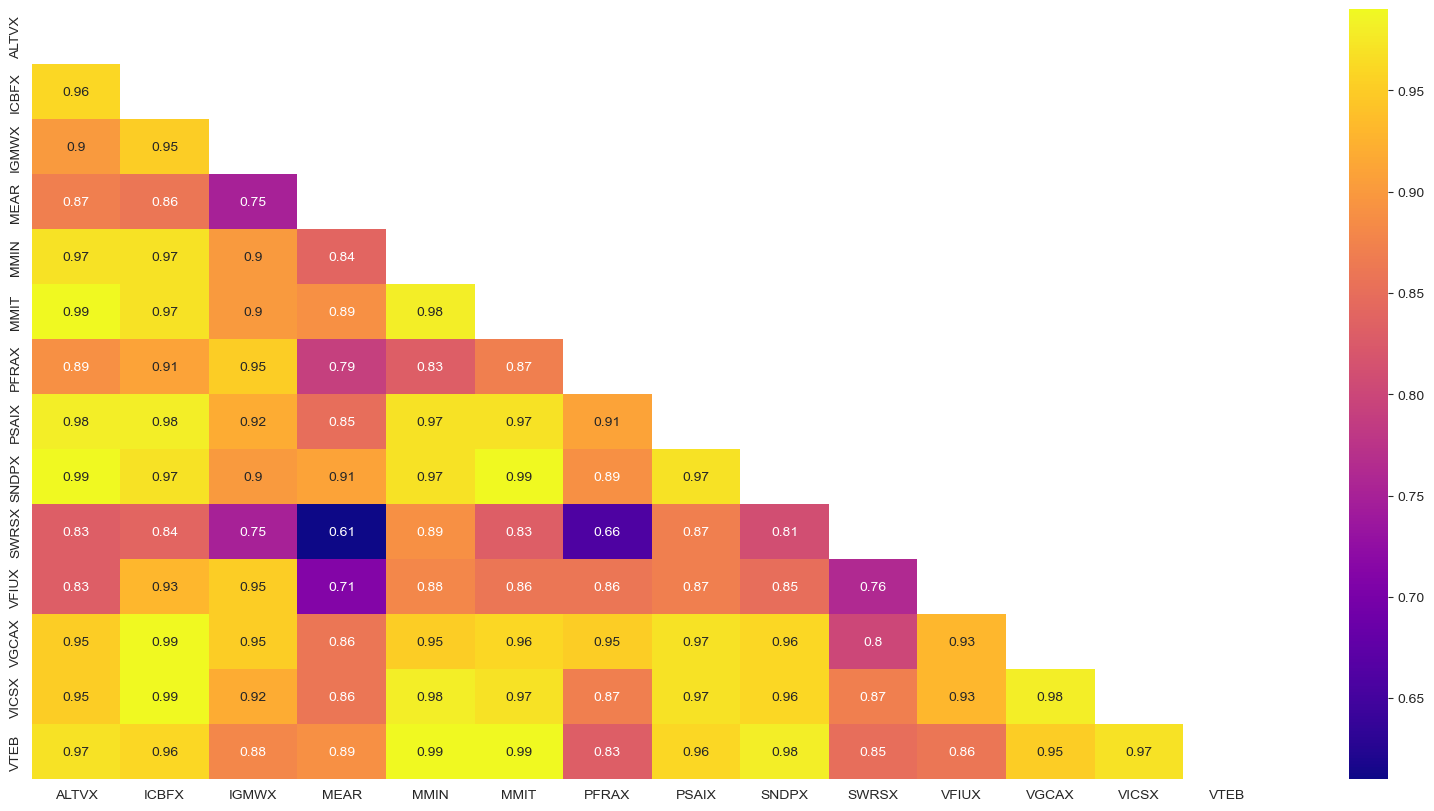

In [441]:
plt.figure(figsize=(20,10))
mask = np.zeros_like(price_int_df.corr())
mask[np.triu_indices_from(mask)] = True
sns.set_style("white")
_p = sns.heatmap(price_int_df.corr().round(2), 
                 annot=True, mask=mask, 
                 cmap="plasma", annot_kws={"size": 10})

### Sharpe

In [442]:
port_ret_weighted= return_int_df.mul(weight_lst, axis=1)
port_ret_weighted

,ALTVX,ICBFX,IGMWX,MEAR,MMIN,MMIT,PFRAX,PSAIX,SNDPX,SWRSX,VFIUX,VGCAX,VICSX,VTEB
Date,,,,,,,,,,,,,,
2018-10-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-10-09,-0.000024,0.000000,0.000081,0.000013,-0.000005,0.000000,0.000000,0.000011,-0.000009,0.000067,0.000062,NaN,0.000011,0.000002
2018-10-10,-0.000024,-0.000017,0.000000,-0.000005,-0.000024,0.000000,0.000000,-0.000023,-0.000017,-0.000134,0.000062,NaN,0.000011,-0.000021
2018-10-11,0.000012,0.000034,0.000081,0.000022,0.000000,0.000000,0.000000,0.000023,0.000000,0.000202,0.000124,NaN,0.000043,0.000014
2018-10-12,0.000000,-0.000017,-0.000081,-0.000033,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000062,NaN,-0.000032,-0.000017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-02,-0.000039,-0.000101,-0.000559,-0.000034,-0.000084,-0.000081,-0.000025,-0.000062,-0.000018,-0.000507,-0.000343,-0.000060,-0.000187,-0.000097
2023-10-03,-0.000039,-0.000102,-0.000658,0.000010,-0.000063,-0.000026,-0.000051,-0.000063,-0.000027,-0.000438,-0.000344,-0.000080,-0.000200,-0.000035
2023-10-04,0.000000,0.000062,0.000570,-0.000001,0.000032,0.000031,-0.000038,-0.000013,0.000000,0.000294,0.000277,0.000054,0.000131,0.000040


In [443]:
return_int_df['Portfolio']= port_ret_weighted.sum(axis=1).dropna()
return_int_df

,ALTVX,ICBFX,IGMWX,MEAR,MMIN,MMIT,PFRAX,PSAIX,SNDPX,SWRSX,VFIUX,VGCAX,VICSX,VTEB,Portfolio
Date,,,,,,,,,,,,,,,
2018-10-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
2018-10-09,-0.002004,0.000000,0.001232,0.001084,-0.000409,0.000000,0.000000,0.000951,-0.000714,0.000936,0.000943,NaN,0.000449,0.000200,0.000210
2018-10-10,-0.002008,-0.001435,0.000000,-0.000401,-0.002044,0.000000,0.000000,-0.001899,-0.001430,-0.001871,0.000942,NaN,0.000449,-0.001796,-0.000193
2018-10-11,0.001006,0.002874,0.001230,0.001805,0.000000,0.000000,0.000000,0.001903,0.000000,0.002812,0.001881,NaN,0.001795,0.001199,0.000554
2018-10-12,0.000000,-0.001433,-0.001229,-0.002803,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000939,NaN,-0.001344,-0.001397,-0.000242
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-02,-0.003272,-0.008489,-0.008511,-0.002831,-0.007002,-0.006809,-0.002130,-0.005219,-0.001494,-0.007078,-0.005214,-0.005014,-0.007828,-0.008108,-0.002198
2023-10-03,-0.003282,-0.008562,-0.010014,0.000825,-0.005289,-0.002142,-0.004269,-0.005247,-0.002244,-0.006110,-0.005241,-0.006719,-0.008383,-0.002934,-0.002117
2023-10-04,0.000000,0.005181,0.008671,-0.000101,0.002658,0.002576,-0.003215,-0.001055,0.000000,0.004098,0.004215,0.004510,0.005470,0.003363,0.001437


In [444]:
#tickers='^DJA'
tickers = 'FHNFX'
DJA = pdr.get_data_yahoo(tickers=tickers, period=period)
return_int_df['Benchmark']= DJA['Close']
return_int_df['Benchmark']= return_int_df['Benchmark'].pct_change(1) #.dropna()
#return_df= return_df.dropna()
return_int_df

[*********************100%%**********************]  1 of 1 completed


,ALTVX,ICBFX,IGMWX,MEAR,MMIN,MMIT,PFRAX,PSAIX,SNDPX,SWRSX,VFIUX,VGCAX,VICSX,VTEB,Portfolio,Benchmark
Date,,,,,,,,,,,,,,,,
2018-10-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN
2018-10-09,-0.002004,0.000000,0.001232,0.001084,-0.000409,0.000000,0.000000,0.000951,-0.000714,0.000936,0.000943,NaN,0.000449,0.000200,0.000210,0.001020
2018-10-10,-0.002008,-0.001435,0.000000,-0.000401,-0.002044,0.000000,0.000000,-0.001899,-0.001430,-0.001871,0.000942,NaN,0.000449,-0.001796,-0.000193,0.000000
2018-10-11,0.001006,0.002874,0.001230,0.001805,0.000000,0.000000,0.000000,0.001903,0.000000,0.002812,0.001881,NaN,0.001795,0.001199,0.000554,0.003058
2018-10-12,0.000000,-0.001433,-0.001229,-0.002803,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000939,NaN,-0.001344,-0.001397,-0.000242,-0.001016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-02,-0.003272,-0.008489,-0.008511,-0.002831,-0.007002,-0.006809,-0.002130,-0.005219,-0.001494,-0.007078,-0.005214,-0.005014,-0.007828,-0.008108,-0.002198,-0.005663
2023-10-03,-0.003282,-0.008562,-0.010014,0.000825,-0.005289,-0.002142,-0.004269,-0.005247,-0.002244,-0.006110,-0.005241,-0.006719,-0.008383,-0.002934,-0.002117,-0.005695
2023-10-04,0.000000,0.005181,0.008671,-0.000101,0.002658,0.002576,-0.003215,-0.001055,0.000000,0.004098,0.004215,0.004510,0.005470,0.003363,0.001437,0.004582


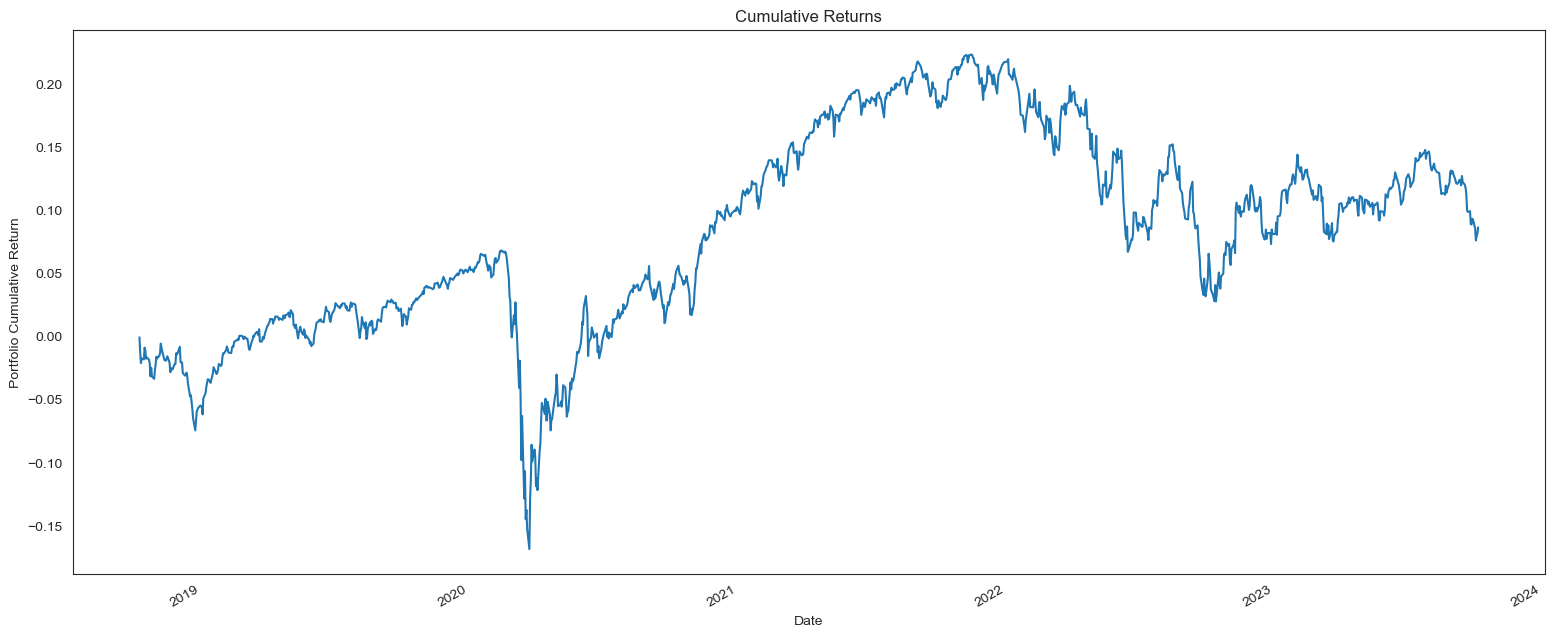

In [484]:
cum_ret_port = ((1 + return_econ_df['Portfolio']).cumprod()-1)
cum_ret_port.plot(label='Cumulative Returns of the Portfolio' ,figsize=(19,8),title='Cumulative Returns - Interest')
_=plt.xlabel('Date' )
_=plt.ylabel('Portfolio Cumulative Return' )

In [446]:
port_bench = pd.concat([return_int_df['Portfolio' ],return_int_df['Benchmark' ]],axis=1 ).dropna()
port_bench.columns=['Portfolio',' Benchmark' ]
correlation=port_bench.corr()
correlation

,Portfolio,Benchmark
Portfolio,1.000000,0.840301
Benchmark,0.840301,1.000000


In [447]:
return_int_df['RF Rate']= rf_rate
return_int_df

,ALTVX,ICBFX,IGMWX,MEAR,MMIN,MMIT,PFRAX,PSAIX,SNDPX,SWRSX,VFIUX,VGCAX,VICSX,VTEB,Portfolio,Benchmark,RF Rate
Date,,,,,,,,,,,,,,,,,
2018-10-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,-0.000085
2018-10-09,-0.002004,0.000000,0.001232,0.001084,-0.000409,0.000000,0.000000,0.000951,-0.000714,0.000936,0.000943,NaN,0.000449,0.000200,0.000210,0.001020,-0.000085
2018-10-10,-0.002008,-0.001435,0.000000,-0.000401,-0.002044,0.000000,0.000000,-0.001899,-0.001430,-0.001871,0.000942,NaN,0.000449,-0.001796,-0.000193,0.000000,-0.000085
2018-10-11,0.001006,0.002874,0.001230,0.001805,0.000000,0.000000,0.000000,0.001903,0.000000,0.002812,0.001881,NaN,0.001795,0.001199,0.000554,0.003058,-0.000085
2018-10-12,0.000000,-0.001433,-0.001229,-0.002803,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000939,NaN,-0.001344,-0.001397,-0.000242,-0.001016,-0.000085
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-02,-0.003272,-0.008489,-0.008511,-0.002831,-0.007002,-0.006809,-0.002130,-0.005219,-0.001494,-0.007078,-0.005214,-0.005014,-0.007828,-0.008108,-0.002198,-0.005663,-0.000085
2023-10-03,-0.003282,-0.008562,-0.010014,0.000825,-0.005289,-0.002142,-0.004269,-0.005247,-0.002244,-0.006110,-0.005241,-0.006719,-0.008383,-0.002934,-0.002117,-0.005695,-0.000085
2023-10-04,0.000000,0.005181,0.008671,-0.000101,0.002658,0.002576,-0.003215,-0.001055,0.000000,0.004098,0.004215,0.004510,0.005470,0.003363,0.001437,0.004582,-0.000085


In [448]:
sharpe_ratio=((return_int_df['Portfolio'].mean() - return_int_df['RF Rate'].mean()))/return_int_df['Portfolio' ].std()
round(sharpe_ratio,4)

0.0636

In [449]:
avg = return_int_df['Portfolio'].mean() * 100
print(f"Portfolio Return Mean: {avg:.7f}")

Portfolio Return Mean: -0.0027182


In [450]:
std = return_int_df['Portfolio' ].std()
print(f"Portfolio Return Standard Deviation: {std:.7f}")

Portfolio Return Standard Deviation: 0.0009056


# VaR Calculation

#Generate Var-Cov matrix
cov_matrix = return_df.cov()
cov_matrix

#Calculate mean returns for each stock
avg_ret_df = return_df.mean()

#Calculate mean returns for portfolio overall,
#using mean, using dot product formula to
#normalize against investment weights
port_mean = avg_ret_df.dot(weight_lst)

#Calculate portfolio standard deviation
port_stdev = np.sqrt(weight_lst.T.dot(cov_matrix).dot(weight_lst))

#Calculate mean of given investment
mean_investment = (1+port_mean) * initial_investment

#Calculate standard deviation of given investmnet
stdev_investment = initial_investment * port_stdev

## Calculate the inverse of the normal cumulative distribution (PPF)

#Using SciPy ppf method to generate values for the inverse cumulative distribution function to a normal distribution
#https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.norm.html
from scipy.stats import norm
cutoff1 = norm.ppf(alpha, mean_investment, stdev_investment)

#Finally, we can calculate the VaR at our confidence interval
var_1d1 = initial_investment - cutoff1
var_1d1

## Value at risk over n-day time period

# Calculate n Day VaR
var_array = []
num_days = int(30)
for x in range(1, num_days+1):
    var_array.append(np.round(var_1d1 * np.sqrt(x),2))
    print(str(x) + " day VaR @ 95% confidence: " + str(np.round(var_1d1 * np.sqrt(x),2)))

# Build plot
plt.xlabel("Day #")
plt.ylabel("Max portfolio loss (USD)")
plt.title("Max portfolio loss (VaR) over 15-day period")
plt.plot(var_array, "r")

# Sharpe Calculation 

In [416]:
port_ret_weighted= return_df.mul(weight_lst, axis=1)
port_ret_weighted

,ALTVX,ICBFX,IGMWX,MEAR,MMIN,MMIT,PFRAX,PSAIX,SNDPX,SWRSX,VFIUX,VGCAX,VICSX,VTEB
Date,,,,,,,,,,,,,,
2018-10-09,-0.000069,0.000000,0.000234,0.000037,-0.000014,0.000000,0.000000,0.000033,-0.000025,0.000194,0.000179,NaN,0.000031,0.000007
2018-10-10,-0.000069,-0.000049,0.000000,-0.000014,-0.000070,0.000000,0.000000,-0.000065,-0.000049,-0.000387,0.000179,NaN,0.000031,-0.000062
2018-10-11,0.000035,0.000099,0.000233,0.000062,0.000000,0.000000,0.000000,0.000066,0.000000,0.000582,0.000357,NaN,0.000124,0.000041
2018-10-12,0.000000,-0.000049,-0.000233,-0.000097,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000178,NaN,-0.000093,-0.000048
2018-10-15,0.000000,0.000000,0.000000,0.000048,0.000000,0.000000,0.000032,0.000033,0.000025,-0.000193,0.000178,NaN,0.000093,-0.000014
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-02,-0.000113,-0.000293,-0.001614,-0.000098,-0.000241,-0.000235,-0.000073,-0.000180,-0.000052,-0.001464,-0.000989,-0.000173,-0.000540,-0.000280
2023-10-03,-0.000113,-0.000295,-0.001899,0.000028,-0.000182,-0.000074,-0.000147,-0.000181,-0.000077,-0.001264,-0.000994,-0.000232,-0.000578,-0.000101
2023-10-04,0.000000,0.000179,0.001644,-0.000003,0.000092,0.000089,-0.000111,-0.000036,0.000000,0.000848,0.000799,0.000156,0.000377,0.000116


In [417]:
return_df['Portfolio']= port_ret_weighted.sum(axis=1).dropna()
return_df

,ALTVX,ICBFX,IGMWX,MEAR,MMIN,MMIT,PFRAX,PSAIX,SNDPX,SWRSX,VFIUX,VGCAX,VICSX,VTEB,Portfolio
Date,,,,,,,,,,,,,,,
2018-10-09,-0.002004,0.000000,0.001232,0.001084,-0.000409,0.000000,0.000000,0.000951,-0.000714,0.000936,0.000943,NaN,0.000449,0.000200,0.000606
2018-10-10,-0.002008,-0.001435,0.000000,-0.000401,-0.002044,0.000000,0.000000,-0.001899,-0.001430,-0.001871,0.000942,NaN,0.000449,-0.001796,-0.000557
2018-10-11,0.001006,0.002874,0.001230,0.001805,0.000000,0.000000,0.000000,0.001903,0.000000,0.002812,0.001881,NaN,0.001795,0.001199,0.001599
2018-10-12,0.000000,-0.001433,-0.001229,-0.002803,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000939,NaN,-0.001344,-0.001397,-0.000698
2018-10-15,0.000000,0.000000,0.000000,0.001405,0.000000,0.000000,0.000935,0.000950,0.000716,-0.000935,0.000940,NaN,0.001346,-0.000400,0.000202
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-02,-0.003272,-0.008489,-0.008511,-0.002831,-0.007002,-0.006809,-0.002130,-0.005219,-0.001494,-0.007078,-0.005214,-0.005014,-0.007828,-0.008108,-0.006344
2023-10-03,-0.003282,-0.008562,-0.010014,0.000825,-0.005289,-0.002142,-0.004269,-0.005247,-0.002244,-0.006110,-0.005241,-0.006719,-0.008383,-0.002934,-0.006110
2023-10-04,0.000000,0.005181,0.008671,-0.000101,0.002658,0.002576,-0.003215,-0.001055,0.000000,0.004098,0.004215,0.004510,0.005470,0.003363,0.004149


In [418]:
#tickers='^DJA'
tickers = 'FHNFX'
DJA = pdr.get_data_yahoo(tickers=tickers, period=period)
return_df['Benchmark']= DJA['Close']
return_df['Benchmark']= return_df['Benchmark'].pct_change(1) #.dropna()
#return_df= return_df.dropna()
return_df

[*********************100%%**********************]  1 of 1 completed


,ALTVX,ICBFX,IGMWX,MEAR,MMIN,MMIT,PFRAX,PSAIX,SNDPX,SWRSX,VFIUX,VGCAX,VICSX,VTEB,Portfolio,Benchmark
Date,,,,,,,,,,,,,,,,
2018-10-09,-0.002004,0.000000,0.001232,0.001084,-0.000409,0.000000,0.000000,0.000951,-0.000714,0.000936,0.000943,NaN,0.000449,0.000200,0.000606,NaN
2018-10-10,-0.002008,-0.001435,0.000000,-0.000401,-0.002044,0.000000,0.000000,-0.001899,-0.001430,-0.001871,0.000942,NaN,0.000449,-0.001796,-0.000557,0.000000
2018-10-11,0.001006,0.002874,0.001230,0.001805,0.000000,0.000000,0.000000,0.001903,0.000000,0.002812,0.001881,NaN,0.001795,0.001199,0.001599,0.003058
2018-10-12,0.000000,-0.001433,-0.001229,-0.002803,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000939,NaN,-0.001344,-0.001397,-0.000698,-0.001016
2018-10-15,0.000000,0.000000,0.000000,0.001405,0.000000,0.000000,0.000935,0.000950,0.000716,-0.000935,0.000940,NaN,0.001346,-0.000400,0.000202,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-02,-0.003272,-0.008489,-0.008511,-0.002831,-0.007002,-0.006809,-0.002130,-0.005219,-0.001494,-0.007078,-0.005214,-0.005014,-0.007828,-0.008108,-0.006344,-0.005663
2023-10-03,-0.003282,-0.008562,-0.010014,0.000825,-0.005289,-0.002142,-0.004269,-0.005247,-0.002244,-0.006110,-0.005241,-0.006719,-0.008383,-0.002934,-0.006110,-0.005695
2023-10-04,0.000000,0.005181,0.008671,-0.000101,0.002658,0.002576,-0.003215,-0.001055,0.000000,0.004098,0.004215,0.004510,0.005470,0.003363,0.004149,0.004582


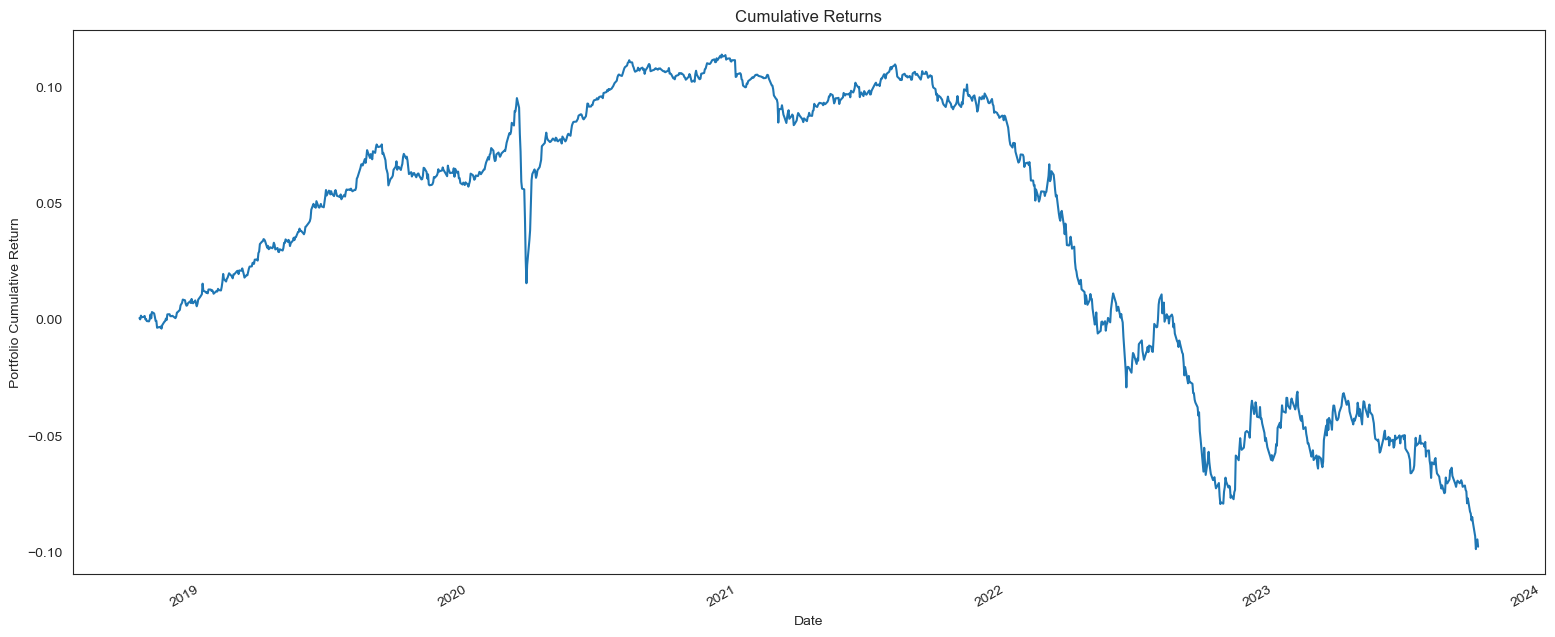

In [419]:
cum_ret_port = ((1 + return_df['Portfolio']).cumprod()-1)
cum_ret_port.plot(label='Cumulative Returns of the Portfolio' ,figsize=(19,8),title='Cumulative Returns')
_=plt.xlabel('Date' )
_=plt.ylabel('Portfolio Cumulative Return' )

In [420]:
port_bench = pd.concat([return_df['Portfolio' ],return_df['Benchmark' ]],axis=1 ).dropna()
port_bench.columns=['Portfolio',' Benchmark' ]
correlation=port_bench.corr()
correlation

,Portfolio,Benchmark
Portfolio,1.000000,0.840292
Benchmark,0.840292,1.000000


In [421]:
return_df['RF Rate']= rf_rate
return_df

,ALTVX,ICBFX,IGMWX,MEAR,MMIN,MMIT,PFRAX,PSAIX,SNDPX,SWRSX,VFIUX,VGCAX,VICSX,VTEB,Portfolio,Benchmark,RF Rate
Date,,,,,,,,,,,,,,,,,
2018-10-09,-0.002004,0.000000,0.001232,0.001084,-0.000409,0.000000,0.000000,0.000951,-0.000714,0.000936,0.000943,NaN,0.000449,0.000200,0.000606,NaN,-0.000085
2018-10-10,-0.002008,-0.001435,0.000000,-0.000401,-0.002044,0.000000,0.000000,-0.001899,-0.001430,-0.001871,0.000942,NaN,0.000449,-0.001796,-0.000557,0.000000,-0.000085
2018-10-11,0.001006,0.002874,0.001230,0.001805,0.000000,0.000000,0.000000,0.001903,0.000000,0.002812,0.001881,NaN,0.001795,0.001199,0.001599,0.003058,-0.000085
2018-10-12,0.000000,-0.001433,-0.001229,-0.002803,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000939,NaN,-0.001344,-0.001397,-0.000698,-0.001016,-0.000085
2018-10-15,0.000000,0.000000,0.000000,0.001405,0.000000,0.000000,0.000935,0.000950,0.000716,-0.000935,0.000940,NaN,0.001346,-0.000400,0.000202,0.000000,-0.000085
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-02,-0.003272,-0.008489,-0.008511,-0.002831,-0.007002,-0.006809,-0.002130,-0.005219,-0.001494,-0.007078,-0.005214,-0.005014,-0.007828,-0.008108,-0.006344,-0.005663,-0.000085
2023-10-03,-0.003282,-0.008562,-0.010014,0.000825,-0.005289,-0.002142,-0.004269,-0.005247,-0.002244,-0.006110,-0.005241,-0.006719,-0.008383,-0.002934,-0.006110,-0.005695,-0.000085
2023-10-04,0.000000,0.005181,0.008671,-0.000101,0.002658,0.002576,-0.003215,-0.001055,0.000000,0.004098,0.004215,0.004510,0.005470,0.003363,0.004149,0.004582,-0.000085


In [422]:
return_df['excess_b']= return_df['Benchmark'] - return_df['RF Rate' ]

In [423]:
sharpe_ratio=((return_df['Portfolio'].mean() - return_df['RF Rate'].mean()))/return_df['Portfolio' ].std()
round(sharpe_ratio,4)

0.0024

In [424]:
avg = return_df['Portfolio'].mean() * 100
print(f"Portfolio Return Mean: {avg:.7f}")

Portfolio Return Mean: -0.0078534


In [425]:
std = return_df['Portfolio' ].std()
print(f"Portfolio Return Standard Deviation: {std:.7f}")

Portfolio Return Standard Deviation: 0.0026153
